<b>1. Импортируем необходимые библиотеки</b>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from sklearn import preprocessing, linear_model, model_selection, metrics
from sklearn.utils import shuffle

In [2]:
# функция для удаления выбросов (больше чем в 1.5 IQR в обе стороны от медианы)
def del_outliers_qq(data, perem):
    Q1 = data[perem].quantile(0.25)
    Q3 = data[perem].quantile(0.75)
    IQR = Q3 - Q1
    Q1_IQR, Q3_IQR  = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    return data[(data[perem] > Q1_IQR) & (data[perem] < Q3_IQR)]

In [3]:
# фукнция для загрузки тренировочных данных
def load_data(path_data, path_target):
    return pd.concat([pd.read_csv(path_data, index_col=0),
                      pd.read_csv(path_target, index_col=0)], axis=1).reset_index(drop=True)

<b>2. Считываем файлы с данными для обучения и тестирования, посмотрим на них (пропущенные значения, типы, количество)</b>

In [4]:
data = load_data('linreg_train.csv', 'linreg_y_train.csv')
data.head()

,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,car_maker,price
0,Passat,2019,Manual,15435,Diesel,150,51.4,2.0,vw,16795
1,A Class,2019,Semi-Auto,17945,Diesel,145,65.7,1.5,mercedes,18480
2,Focus,2017,Manual,20102,Petrol,20,60.1,1.0,ford,9995
3,C-HR,2018,Automatic,8661,Hybrid,135,74.3,1.8,toyota,20995
4,Fiesta,2020,Manual,10,Petrol,150,58.9,1.0,ford,17000


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64556 entries, 0 to 64555
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         64556 non-null  object 
 1   year          64556 non-null  int64  
 2   transmission  64556 non-null  object 
 3   mileage       64556 non-null  int64  
 4   fuelType      64556 non-null  object 
 5   tax           64556 non-null  int64  
 6   mpg           64556 non-null  float64
 7   engineSize    64556 non-null  float64
 8   car_maker     64556 non-null  object 
 9   price         64556 non-null  int64  
dtypes: float64(2), int64(4), object(4)
memory usage: 4.9+ MB


Интуитивно понятно, что на цену машины влияет год производства, трансмиссия, пробег, марка автомобиля, объём двигателя. У нас есть категориальные признаки - transmission, fueltype, car_maker, остальные являются вещественными (кроме name). Неообходимо заменить категориальные признаки на числовые. Рассмотрим признак model - уберем пробел и посмотрим на уникальные значения 

In [6]:
data.model = data.model.str.strip()
data.model.nunique()

155

Как можно видеть - значений уникальных много, но стоит принять во внимание, что признаков скорее всего достаточно для идентификации марки автомобиля, поэтому использовать model было бы нецелесообразно 

In [7]:
data_copy = copy.copy(data[:])
data_copy.drop(columns=['model'], inplace=True)
data_copy.head()

,year,transmission,mileage,fuelType,tax,mpg,engineSize,car_maker,price
0,2019,Manual,15435,Diesel,150,51.4,2.0,vw,16795
1,2019,Semi-Auto,17945,Diesel,145,65.7,1.5,mercedes,18480
2,2017,Manual,20102,Petrol,20,60.1,1.0,ford,9995
3,2018,Automatic,8661,Hybrid,135,74.3,1.8,toyota,20995
4,2020,Manual,10,Petrol,150,58.9,1.0,ford,17000


<b>2. Преобразуем категориальные данные с помощью dummies (или же OneHotEncoder)</b>

In [8]:
data_copy = pd.get_dummies(data_copy, drop_first=False)

<b>3. После преобразования данных давайте посмотрим на выбросы или аномалии в данных</b>

In [9]:
data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64556 entries, 0 to 64555
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   year                    64556 non-null  int64  
 1   mileage                 64556 non-null  int64  
 2   tax                     64556 non-null  int64  
 3   mpg                     64556 non-null  float64
 4   engineSize              64556 non-null  float64
 5   price                   64556 non-null  int64  
 6   transmission_Automatic  64556 non-null  uint8  
 7   transmission_Manual     64556 non-null  uint8  
 8   transmission_Other      64556 non-null  uint8  
 9   transmission_Semi-Auto  64556 non-null  uint8  
 10  fuelType_Diesel         64556 non-null  uint8  
 11  fuelType_Electric       64556 non-null  uint8  
 12  fuelType_Hybrid         64556 non-null  uint8  
 13  fuelType_Other          64556 non-null  uint8  
 14  fuelType_Petrol         64556 non-null

<b>3.1 Рассмотрим типы трансмиссий</b>

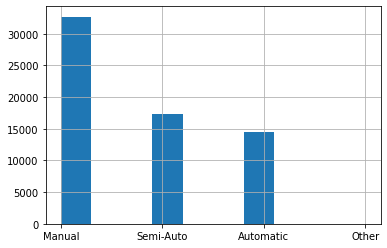

In [10]:
data.transmission.hist()

Трансмисси 'Other' слишком мало, давайте посмотрим на неё:

In [11]:
data[data.transmission == 'Other']

,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,car_maker,price
4062,SLK,2015,Other,39000,Diesel,150,56.5,2.1,mercedes,12995
37861,Scala,2019,Other,3500,Petrol,145,47.1,1.0,skoda,15999
44485,Yaris,2015,Other,16733,Hybrid,0,78.0,1.5,toyota,12795
51266,GLA Class,2016,Other,30895,Other,125,56.5,0.0,mercedes,18700


Для данных значений попытаемся из Интернета найти правильную трансмиссию или предположить к какой относятся:  
- <i>GLA Class</i> - обращаем внимание на engineSize (равен 0.0), из информации в интернете - полностью элекрические SUV были анонсированы только в 2020-ом году, а здесь у idnex=51266 стоит 2016. Значит, это наблюдение - ошибка.  
- <i>SLK</i> - по идее должна быть автоматическая кпп  
- <i>Scala</i> - роботизированная кпп - пусть будет автоматическая кпп    
- <i>Yaris</i> - автоматическая кпп

In [12]:
data_copy.at[[4062, 37861, 44485],  'transmission_Automatic'] = 1
data_copy.drop(columns=['transmission_Other'], inplace=True)
data_copy = data_copy.drop([51266]).reset_index(drop=True)

In [13]:
data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64555 entries, 0 to 64554
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   year                    64555 non-null  int64  
 1   mileage                 64555 non-null  int64  
 2   tax                     64555 non-null  int64  
 3   mpg                     64555 non-null  float64
 4   engineSize              64555 non-null  float64
 5   price                   64555 non-null  int64  
 6   transmission_Automatic  64555 non-null  uint8  
 7   transmission_Manual     64555 non-null  uint8  
 8   transmission_Semi-Auto  64555 non-null  uint8  
 9   fuelType_Diesel         64555 non-null  uint8  
 10  fuelType_Electric       64555 non-null  uint8  
 11  fuelType_Hybrid         64555 non-null  uint8  
 12  fuelType_Other          64555 non-null  uint8  
 13  fuelType_Petrol         64555 non-null  uint8  
 14  car_maker_audi          64555 non-null

<b> 3.2 Давайте посмотрим тип топлива в машинках</b>

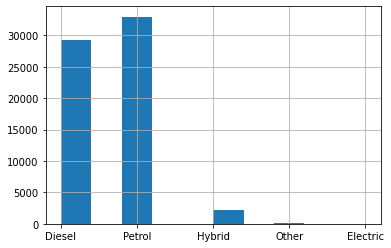

In [14]:
data.fuelType.hist()

Посмотрим на машинки с типом топлива 'Electric'

In [15]:
data[data.fuelType == 'Electric']

,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,car_maker,price
5818,i3,2015,Automatic,29465,Electric,0,470.8,1.0,bmw,17400
8260,Mondeo,2016,Automatic,24531,Electric,0,67.3,2.0,ford,15500
17366,i3,2017,Automatic,20321,Electric,135,470.8,0.0,bmw,18999
27679,Mondeo,2016,Automatic,9396,Electric,0,67.3,2.0,ford,15975
43057,i3,2016,Automatic,9990,Electric,0,470.8,0.0,bmw,18999


i3 от BMW является первый серийным электрокаром, соответственно, EngineSize у него должен быть равен 0. Но с другой стороны у данной модели есть компоновка с ДВС, так называемым Range Extender (BMW i3 REX), что позволяет всё-таки отнести i3 к гибридным автомобилям.
Ford Mondeo является элекрическим гибридным автомобилем.

In [16]:
data_copy.at[data_copy[data_copy.fuelType_Electric == 1].index,  'fuelType_Hybrid'] = 1
data_copy.drop(columns=['fuelType_Electric'], inplace=True)

Посмотрим на тип 'Other'

In [17]:
data[data.fuelType == 'Other'].shape[0]

187

187 машин, пусть живут :)

<b>3.3 Посмотрим на цены машинок</b>

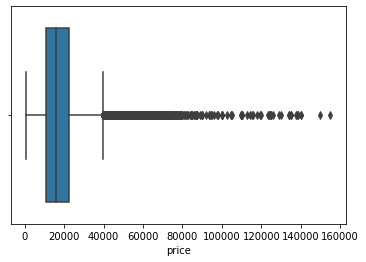

In [18]:
sns.boxplot(x=data_copy.price)

In [19]:
data_copy[data_copy.price > 40000].shape

(2264, 20)

Интересно, что есть очень дорогие автомобили (от 3 млн рублей, то есть можно считать более 40000 долларов США)

Можно сказать, что премиальные машины (например, R8) всё-таки есть, и это можно не считать за выбросы.
<table>
<tr>
<td><img src="https://cdn.motor1.com/images/mgl/JmVR6/s1/4x3/2019-audi-r8-onlocation.webp" width="200" width=270 height=480></td>
    <td><img src="https://avatars.mds.yandex.net/get-verba/1030388/2a000001608e69f77d8b18b042ab0035c6b3/cattouchret" width=270 height=480></td>
</tr>
</table>

<b>3.4 Посмотрим на год производства автомобилей</b>

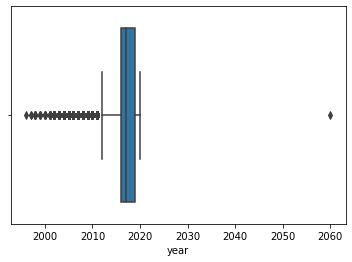

In [20]:
sns.boxplot(x = data_copy['year'])

In [21]:
data[data.year > 2020]

,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,car_maker,price
31534,Fiesta,2060,Automatic,54807,Petrol,205,42.8,1.4,ford,6495


Видим что у нас 2060 есть герой одного фильма про путешествия в будущее 😄 , давайте отправим машину с таким годом в свободный полет, как неподходящую по условию (до 2020 года)
<table>
<tr>
<td><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/7/7d/2017_Ford_Fiesta_Zetec_Turbo_1.0_Front.jpg/305px-2017_Ford_Fiesta_Zetec_Turbo_1.0_Front.jpg" width="400" height=480></td>
</tr>
</table>

In [22]:
data_copy = data_copy.drop(data_copy[data_copy.year>2020].index).reset_index(drop=True)

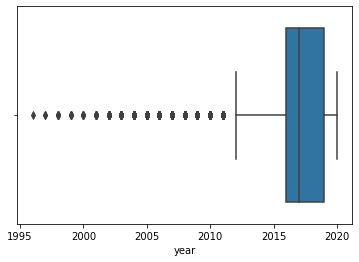

In [23]:
sns.boxplot(x = data_copy['year'])

2060-ый год ушел, но остались машины примерно с 1995 по 2012 год

In [24]:
old_vehicle = data[(data.year < 2012)].sort_values(by=['year', 'mileage', 'price'])

In [25]:
old_vehicle.describe()

,year,mileage,tax,mpg,engineSize,price
count,1120.000000,1120.000000,1120.000000,1120.000000,1120.000000,1120.000000
mean,2008.340179,81873.208036,203.120536,45.197946,1.956607,5468.081250
std,2.745602,31685.236345,119.313529,10.979947,0.727999,5678.601764
min,1996.000000,1.000000,0.000000,17.800000,0.000000,650.000000
25%,2007.000000,62000.000000,145.000000,37.700000,1.600000,2990.000000
50%,2009.000000,80000.000000,200.000000,44.800000,2.000000,4490.000000
75%,2010.000000,99000.000000,260.000000,52.300000,2.000000,6499.250000
max,2011.000000,323000.000000,580.000000,76.300000,6.200000,149948.000000


В целом тут ничего страшного нет, если только посмотреть на цену в 149948:

In [26]:
old_vehicle[old_vehicle.price == 149948]

,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,car_maker,price
2515,SL CLASS,2011,Automatic,3000,Petrol,570,21.4,6.2,mercedes,149948


Mercedec SL Class достаточно дорогая машина, тем более когда пробег достаточно маленький.

<b>3.4 Рассмотрим пробег автомобилей</b>

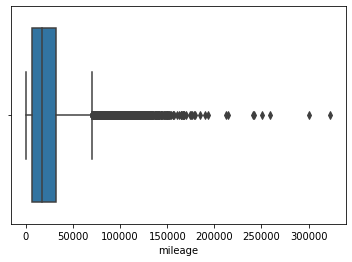

In [27]:
sns.boxplot(x=data_copy.mileage)

In [28]:
data_copy[data_copy.mileage > 200000]

,year,mileage,tax,mpg,engineSize,price,transmission_Automatic,transmission_Manual,transmission_Semi-Auto,fuelType_Diesel,fuelType_Hybrid,fuelType_Other,fuelType_Petrol,car_maker_audi,car_maker_bmw,car_maker_ford,car_maker_mercedes,car_maker_skoda,car_maker_toyota,car_maker_vw
9697,2010,259000,540,30.7,3.0,6949,1,0,0,1,0,0,0,0,0,0,1,0,0,0
12039,2012,212000,325,34.4,2.0,11995,0,0,1,1,0,0,0,0,0,0,0,0,0,1
12472,2010,300000,125,57.6,1.9,1190,0,1,0,1,0,0,0,0,0,0,0,1,0,0
12899,2016,240494,20,68.9,2.1,16249,1,0,0,1,0,0,0,0,0,0,1,0,0,0
14882,2010,250650,125,57.6,1.9,1485,0,1,0,1,0,0,0,0,0,0,0,1,0,0
23771,2012,214000,300,37.7,3.0,7250,1,0,0,1,0,0,0,0,1,0,0,0,0,0
30745,2009,241565,185,47.9,1.9,2750,1,0,0,1,0,0,0,0,0,0,0,1,0,0
47929,2008,323000,200,44.1,2.0,2490,0,1,0,1,0,0,0,1,0,0,0,0,0,0


In [29]:
data[data.mileage > 200000]

,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,car_maker,price
9697,V Class,2010,Automatic,259000,Diesel,540,30.7,3.0,mercedes,6949
12039,Caravelle,2012,Semi-Auto,212000,Diesel,325,34.4,2.0,vw,11995
12472,Octavia,2010,Manual,300000,Diesel,125,57.6,1.9,skoda,1190
12899,A Class,2016,Automatic,240494,Diesel,20,68.9,2.1,mercedes,16249
14882,Octavia,2010,Manual,250650,Diesel,125,57.6,1.9,skoda,1485
23771,X5,2012,Automatic,214000,Diesel,300,37.7,3.0,bmw,7250
30745,Octavia,2009,Automatic,241565,Diesel,185,47.9,1.9,skoda,2750
47930,A6,2008,Manual,323000,Diesel,200,44.1,2.0,audi,2490


Можно увидеть, что в целом автомобили с большим пробегом имеют меньшую стоимость и по возрасту старше

<b>3.5 Рассмотрим mpg автомобилей</b>

MPG - miles per galoon - Дистанция, при прохождении которой автомобиль израсходует заданный объём топлива. Широко используется в странах с английской системой мер, где расход измеряется как количество миль, которое автомобиль может проехать на одном галлоне (британском или американском) топлива. Зависимост между привычными нам литры / 100 км и MPG является обратной (~ 1 / x). На приведенном ниже boxplot, слева расположены автомобили с низким MPG (например Toyota Hilux), а справа с высоким MPG (i3 электроавтомобиль).

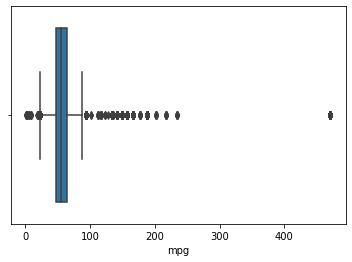

In [30]:
sns.boxplot(x=data_copy.mpg)

Рассмотрим выброс справа ( > 400)

In [31]:
data[(data.mpg > 400)]

,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,car_maker,price
5818,i3,2015,Automatic,29465,Electric,0,470.8,1.0,bmw,17400
5929,i3,2017,Automatic,3976,Hybrid,135,470.8,0.0,bmw,22999
9842,i3,2015,Automatic,65800,Hybrid,0,470.8,0.0,bmw,14285
10657,i3,2016,Automatic,68000,Hybrid,0,470.8,0.0,bmw,15990
10827,i3,2014,Automatic,42479,Hybrid,0,470.8,0.0,bmw,15450
11060,i3,2016,Automatic,8421,Hybrid,0,470.8,0.0,bmw,19490
15669,i3,2016,Automatic,43695,Hybrid,0,470.8,0.0,bmw,16482
15834,i3,2016,Automatic,41063,Other,0,470.8,0.6,bmw,17000
16659,i3,2016,Automatic,35446,Hybrid,0,470.8,0.0,bmw,16500
17366,i3,2017,Automatic,20321,Electric,135,470.8,0.0,bmw,18999


Видно, что это i3 (электрокар), соответственно, у данного автомобиля имеется повышенный mpg

<b>3.6 Рассмотрим распределение цен в зависимости от производителя</b>

In [32]:
data2 = data_copy[['price']]
data2['Maker'] = 1 * data_copy['car_maker_audi'] + 2 * data_copy['car_maker_bmw'] + 3 * data_copy['car_maker_ford'] + 4 * data_copy['car_maker_mercedes'] + 5 * data_copy['car_maker_skoda'] + 6 * data_copy['car_maker_toyota'] + 7 * data_copy['car_maker_vw'] 

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


[Text(0, 0.5, 'Стоимость'), Text(0.5, 0, 'Производитель')]

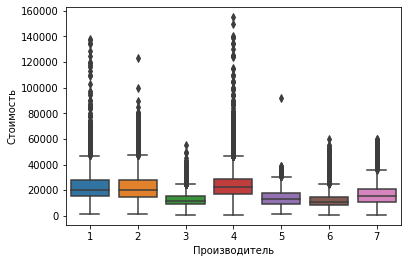

In [33]:
sns.boxplot(y = data2['price'], x = data2['Maker']).set(xlabel = u'Производитель', ylabel = u'Стоимость')

Видно, что у skoda (5) есть очень интересное значение цены, давайте найдём его

In [34]:
data[(data.price > 80000) & (data.car_maker == 'skoda')]

,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,car_maker,price
39164,Karoq,2019,Automatic,3764,Petrol,145,40.9,1.5,skoda,91874


Явно стоимость больше чем обычная цена Karoq, так что отбросим данное значение

In [35]:
data[data.model=='Karoq'].price.median()

20000.0

In [36]:
data_copy = data_copy.drop(data_copy[(data_copy.price > 80000) & (data_copy.car_maker_skoda == 1)].index).reset_index(drop=True)

Также если посмотреть на распределение, то можно увидеть, что в целом у нас Audi, BMW, Mercedes в целом похожи, аналогичная ситуация с Toyota и Ford, поэтому их можно объединить между собой по группам

In [37]:
data_copy['merc_audi_bmw'] = data_copy['car_maker_audi'] + data_copy['car_maker_bmw'] + data_copy['car_maker_mercedes']
data_copy['ford_toyota'] = data_copy['car_maker_ford'] + data_copy['car_maker_toyota']
data_copy.drop(columns=['car_maker_audi', 'car_maker_bmw', 'car_maker_mercedes', 'car_maker_toyota', 'car_maker_ford'], inplace=True)

In [38]:
data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64553 entries, 0 to 64552
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   year                    64553 non-null  int64  
 1   mileage                 64553 non-null  int64  
 2   tax                     64553 non-null  int64  
 3   mpg                     64553 non-null  float64
 4   engineSize              64553 non-null  float64
 5   price                   64553 non-null  int64  
 6   transmission_Automatic  64553 non-null  uint8  
 7   transmission_Manual     64553 non-null  uint8  
 8   transmission_Semi-Auto  64553 non-null  uint8  
 9   fuelType_Diesel         64553 non-null  uint8  
 10  fuelType_Hybrid         64553 non-null  uint8  
 11  fuelType_Other          64553 non-null  uint8  
 12  fuelType_Petrol         64553 non-null  uint8  
 13  car_maker_skoda         64553 non-null  uint8  
 14  car_maker_vw            64553 non-null

<b>4. Трансформация значений к одному масштабу</b>

Теперь необходимо привести все значения к одному масштабу, воспользуемся StandardScaler

In [39]:
scaler_mm = preprocessing.StandardScaler()

In [40]:
num_vals = scaler_mm.fit_transform(data_copy[['year', 'mileage', 'tax', 'mpg', 'engineSize']].values)
num_df = pd.DataFrame(data=num_vals, columns=['year', 'mileage', 'tax', 'mpg', 'engineSize'])

In [41]:
data_copy = data_copy.drop(columns=['year', 'mileage', 'tax', 'mpg', 'engineSize']).merge(num_df, left_index = True, right_index = True, how = 'left') 

In [42]:
data_copy.head()

,price,transmission_Automatic,transmission_Manual,transmission_Semi-Auto,fuelType_Diesel,fuelType_Hybrid,fuelType_Other,fuelType_Petrol,car_maker_skoda,car_maker_vw,merc_audi_bmw,ford_toyota,year,mileage,tax,mpg,engineSize
0,16795,0,1,0,1,0,0,0,0,1,0,0,0.887619,-0.353333,0.483555,-0.260995,0.479243
1,18480,0,0,1,1,0,0,0,0,0,1,0,0.887619,-0.236585,0.406109,0.578239,-0.366906
2,9995,0,1,0,0,0,0,1,0,0,0,1,-0.053366,-0.136256,-1.530047,0.249588,-1.213056
3,20995,1,0,0,0,1,0,0,0,0,0,1,0.417127,-0.668414,0.251216,1.082953,0.140783
4,17000,0,1,0,0,0,0,1,0,0,0,1,1.358112,-1.070800,0.483555,0.179163,-1.213056


<b> 5. Зависимость цены от различных параметров и корреляция </b>

Посмотрим на распределение цены

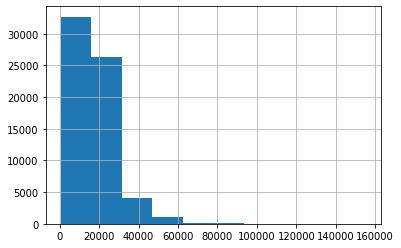

In [43]:
data_copy.price.hist()

Оно является скошенным в левую сторону, поэтому лучше при прогнозировании преобразовать его с помощью log

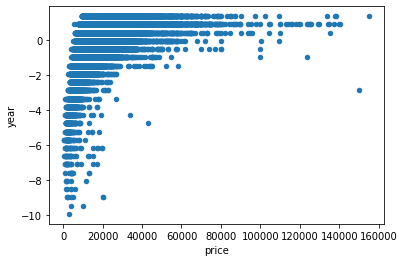

In [44]:
data_copy.plot(x='price', y='year', kind='scatter')

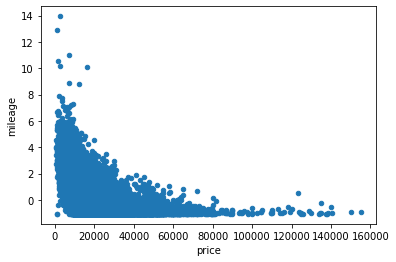

In [45]:
data_copy.plot(x='price', y='mileage', kind='scatter')

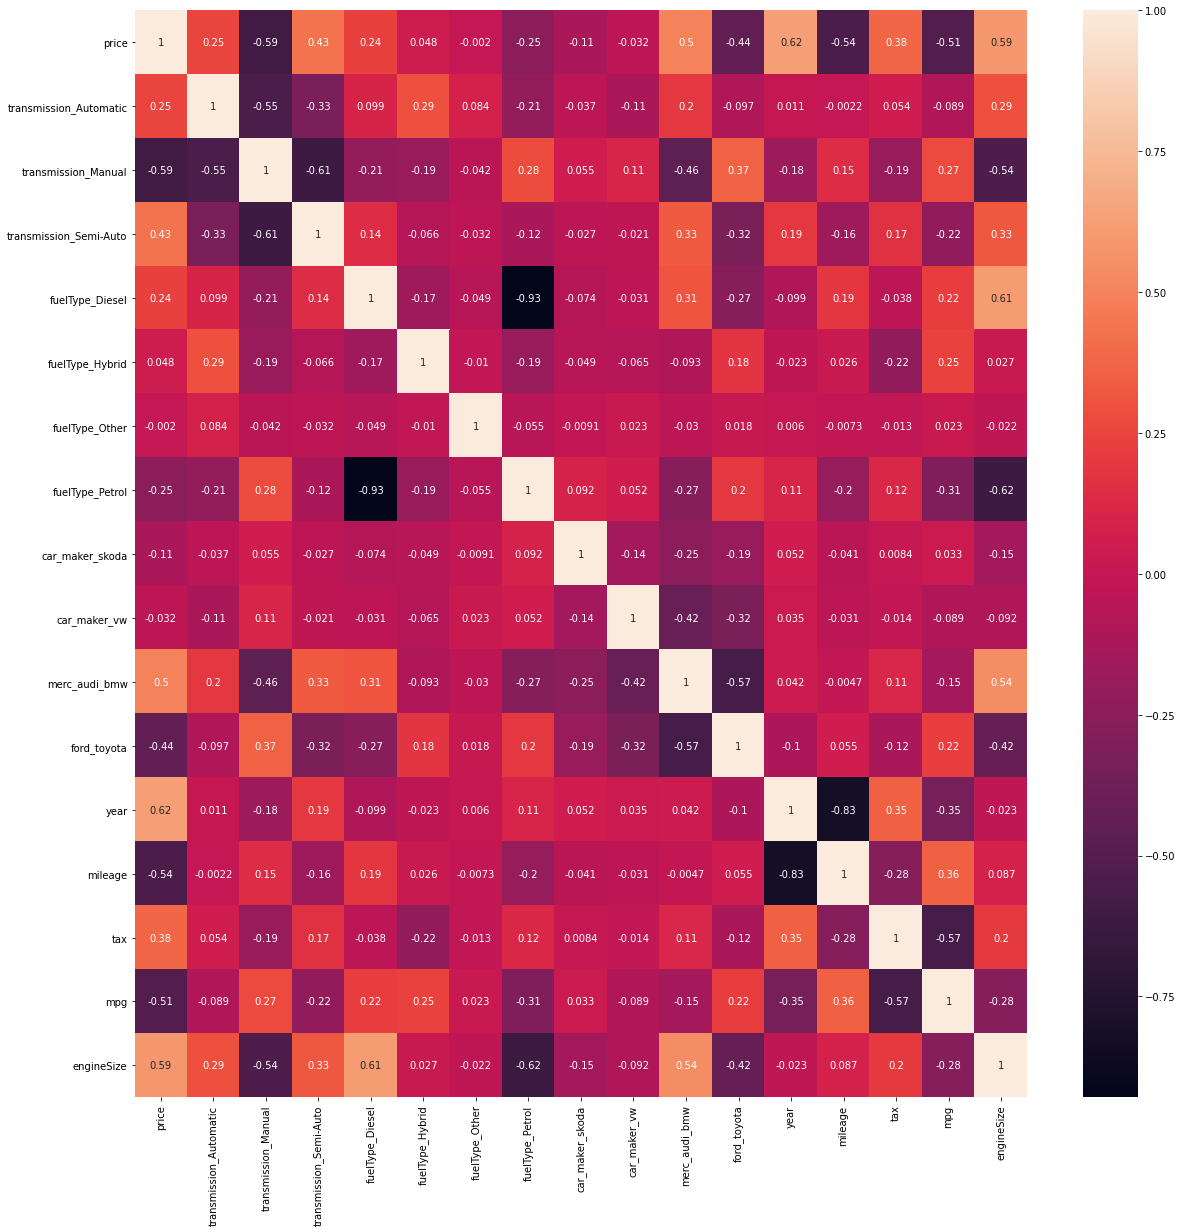

In [46]:
plt.figure(figsize=(20,20))
sns.heatmap(data_copy.corr(method='spearman'), annot=True)

<b> 6. Обучение и прогнозирование </b>

Перемешаем данные

In [47]:
data_copy = shuffle(data_copy, random_state=198)

In [48]:
y = np.log(data_copy['price'])
X = data_copy.drop(columns=['price'])

In [49]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y)

In [50]:
from sklearn.model_selection import GridSearchCV

Text(0, 0.5, 'CV score')

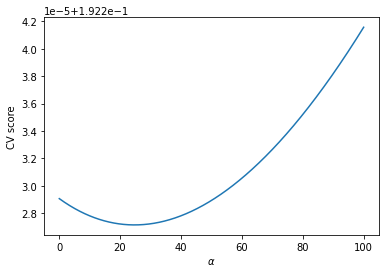

In [51]:
alpha = np.linspace(0.05, 100, 1000)

gs = GridSearchCV(linear_model.Ridge(),
                    {"alpha": alpha},
                    scoring = "neg_root_mean_squared_error", 
                    cv = 5)

gs.fit(X_train, y_train)


plt.plot(alpha, -gs.cv_results_["mean_test_score"])
plt.xlabel(r"$\alpha$")
plt.ylabel("CV score")

In [52]:
print("Best alpha = {0}".format(gs.best_params_["alpha"]))

Best alpha = 24.762362362362364


In [53]:
model_fin = linear_model.Ridge(alpha=gs.best_params_["alpha"])
model_fin.fit(X_train, y_train)

Ridge(alpha=24.762362362362364)

In [54]:
model_fin.fit(X_train, y_train)

Ridge(alpha=24.762362362362364)

In [55]:
def get_score(model_name, model, X_train, X_test, Y_train, Y_test):
    
    pred_test = model.predict(X_test)
    rmse_test = np.sqrt(metrics.mean_squared_error(Y_test, pred_test))
    mae_test = metrics.mean_absolute_error(Y_test, pred_test)
    r2_test = metrics.r2_score(Y_test, pred_test)

    pred_train = model.predict(X_train)
    rmse_train = np.sqrt(metrics.mean_squared_error(Y_train, pred_train))
    mae_train = metrics.mean_absolute_error(Y_train, pred_train)
    r2_train = metrics.r2_score(Y_train, pred_train)

    print(10 * '-' + model_name + 10 * '-')
    print('TRAIN:   RMSE = {:.2f}, R^2 = {:.2f}'.format(rmse_train, r2_train)) 
    print('TRAIN:   MAE = {:.2f}, R^2 = {:.2f}'.format(mae_train, r2_train))
    print("TEST:   RMSE = {:.2f}, R^2 = {:.2f}".format(rmse_test, r2_test))
    print('TEST:   MAE = {:.2f}, R^2 = {:.2f}'.format(mae_test, r2_test))

In [56]:
get_score('Ridge', model_fin, X_train, X_test, y_train, y_test)

----------Ridge----------
TRAIN:   RMSE = 0.19, R^2 = 0.87
TRAIN:   MAE = 0.15, R^2 = 0.87
TEST:   RMSE = 0.19, R^2 = 0.87
TEST:   MAE = 0.15, R^2 = 0.87


Неплохо получилось (Коэфф. детерминации R^2 = 0.87). Давайте загрузим данные, где нужно предсказать цены, и выполним аналогичные операции по преобразованию и конвертации датафрейма

In [68]:
test = pd.read_csv('linreg_test.csv', index_col=0)

In [69]:
predictions = test['id'].to_frame()

In [70]:
test.drop(columns=['id', 'model'], inplace=True)

In [71]:
num_test = scaler_mm.fit_transform(test[['year', 'mileage', 'tax', 'mpg', 'engineSize']].values)
test.drop(columns=['year', 'mileage', 'tax', 'mpg', 'engineSize'], inplace=True)

In [72]:
num_test_df = pd.DataFrame(data=num_test, columns=['year', 'mileage', 'tax', 'mpg', 'engineSize'])

In [73]:
test = pd.get_dummies(test)

In [74]:
def conver_marks(data_copy):
    data_copy['merc_audi_bmw'] = data_copy['car_maker_audi'] + data_copy['car_maker_bmw'] + data_copy['car_maker_mercedes']
    data_copy['ford_toyota'] = data_copy['car_maker_ford'] + data_copy['car_maker_toyota']
    return data_copy.drop(columns=['car_maker_audi', 'car_maker_bmw', 'car_maker_mercedes', 'car_maker_toyota', 'car_maker_ford'])

In [75]:
test = conver_marks(test)

In [76]:
test = pd.concat([test, num_test_df], axis=1)

In [77]:
test.values

array([[ 0.        ,  1.        ,  0.        , ...,  0.39702856,
         0.75987578, -0.37118953],
       [ 0.        ,  1.        ,  0.        , ...,  0.09209143,
        -0.15323728, -0.37118953],
       [ 0.        ,  1.        ,  0.        , ...,  0.39702856,
        -0.46931488, -1.21875996],
       ...,
       [ 1.        ,  0.        ,  0.        , ...,  0.39702856,
         0.03406796, -1.21875996],
       [ 0.        ,  1.        ,  0.        , ...,  0.47326284,
        -0.09470439,  0.4763809 ],
       [ 0.        ,  0.        ,  1.        , ...,  0.39702856,
        -1.3531615 ,  0.4763809 ]])

In [78]:
predictions['price'] = np.exp(model_fin.predict(test.values))

In [79]:
predictions.set_index('id')

,price
id,
0,11544.070130
1,15059.696331
2,15598.803582
3,20046.840804
4,12857.184432
...,...
16134,28401.222300
16135,29512.144708
16136,12894.535111


In [80]:
predictions.to_csv('predictions.csv')

Цены на машины спрогнозированы!